In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import glob
import requests
import cv2
import pathlib
import xml.etree.ElementTree as ET
from tqdm import tqdm
from PIL import Image

Archive:  /content/input.zip
   creating: /content/cat-object-detection/
  inflating: /content/__MACOSX/._cat-object-detection  
  inflating: /content/cat-object-detection/cat.6.xml  
  inflating: /content/__MACOSX/cat-object-detection/._cat.6.xml  
  inflating: /content/cat-object-detection/cat.6.jpg  
  inflating: /content/__MACOSX/cat-object-detection/._cat.6.jpg  
  inflating: /content/cat-object-detection/cat.3823.xml  
  inflating: /content/__MACOSX/cat-object-detection/._cat.3823.xml  
  inflating: /content/cat-object-detection/cat.3604.jpg  
  inflating: /content/__MACOSX/cat-object-detection/._cat.3604.jpg  
  inflating: /content/cat-object-detection/cat.3610.jpg  
  inflating: /content/__MACOSX/cat-object-detection/._cat.3610.jpg  
  inflating: /content/cat-object-detection/cat.3837.xml  
  inflating: /content/__MACOSX/cat-object-detection/._cat.3837.xml  
  inflating: /content/cat-object-detection/cat.3638.jpg  
  inflating: /content/__MACOSX/cat-object-detection/._cat.3638.

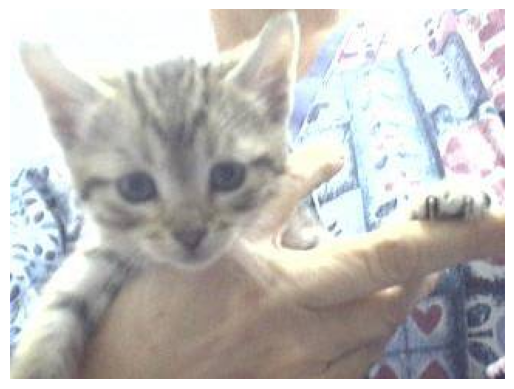

In [2]:
# from google.colab import files
# uploaded = files.upload()

!unzip /content/input.zip -d /content
directory = '/content/cat-object-detection/'
all_images = [file for file in os.listdir(directory) if file.endswith('.jpg')]
random_image = random.choice(all_images)
print("File Name:", random_image)
image_path = os.path.join(directory, random_image)
image = mpimg.imread(image_path)
plt.imshow(image)
plt.axis('off')
plt.show()

In [3]:
# Extracts ground truths like boxes, labels and ids from xml files
def extract_ground_truth(path):

    boxes = []
    labels = []
    ids = []

    tree = ET.parse(path)
    id_i = path.split("/")[-1].split(".")[1]
    objects = tree.getroot().findall("object")

    for object_i in objects:
        object_name = object_i.find("name").text
        if object_name=="cat":
            instances = object_i.findall("bndbox")
            for instance in instances:
                xmin = int(float(instance.find("xmin").text))
                xmax = int(float(instance.find("xmax").text))
                ymin = int(float(instance.find("ymin").text))
                ymax = int(float(instance.find("ymax").text))
                box = np.array([xmin, xmax, ymin, ymax])
                boxes.append(box)
                labels.append(object_name)
                ids.append(id_i)
        return np.array(boxes), np.array(labels), np.array(ids)

In [4]:
# Generates region proposals using Selective Search
def region_proposals(image):

    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(image)
    ss.switchToSelectiveSearchFast()
    rects = ss.process()

    prediction_rects = _restructure_rectangles_xx(rects)
    return prediction_rects

In [5]:
# Converts rectangles from (x, y, w, h) to (x1, x2, y1, y2)
def _restructure_rectangles_xx(old_rects):

    x1 = old_rects[:,0]
    x2 = old_rects[:,2]+old_rects[:,0]
    y1 = old_rects[:,1]
    y2 = old_rects[:,1]+old_rects[:,3]

    rects_new = old_rects.copy()
    rects_new[:,0] = x1
    rects_new[:,1] = x2
    rects_new[:,2] = y1
    rects_new[:,3] = y2
    return rects_new

In [6]:
# Crops boxes and writes images to files
def images_to_file(image, boxes, labels, predicted_rectangles, image_id, path="."):

    if not os.path.exists(f"{path}/{labels[0]}"):
        os.makedirs(f"{path}/{labels[0]}")
    if not os.path.exists(f"{path}/no_category"):
        os.makedirs(f"{path}/no_category")

    for box, label, i_id in zip(boxes, labels, image_id):
        i_pos = i_neg = 0
        for rect in predicted_rectangles:
            iou = _get_iou(box,rect)
            if iou > 0.5:
                i_pos +=1
                file_name = f"{path}/{label}/{i_id}_{i_pos}.jpg"
                cropped_image = image[rect[2]:rect[3], rect[0]:rect[1]]
                img = Image.fromarray(cropped_image, 'RGB')
                img2 = img.resize((227,227), Image.ANTIALIAS)
                img2.save(file_name)
            elif iou < 0.1 and i_neg < 50:
                if (rect[3]-rect[2])>20 and (rect[1]-rect[0])>20:
                    i_neg += 1
                    file_name = f"{path}/no_category/{label}_{i_id}_{i_neg}.jpg"
                    cropped_image = image[rect[2]:rect[3], rect[0]:rect[1]]
                    img = Image.fromarray(cropped_image, 'RGB')
                    img2 = img.resize((227,227), Image.ANTIALIAS)
                    img2.save(file_name)

In [7]:
# Calculate the Intersection over Union (IoU) of two bounding boxes.

#     Parameters
#     ----------
#     bb1 : array
#         Keys: {'x1', 'x2', 'y1', 'y2'}
#         The (x1, y1) position is at the top left corner,
#         the (x2, y2) position is at the bottom right corner
#     bb2 : array
#         Keys: {'x1', 'x2', 'y1', 'y2'}
#         The (x, y) position is at the top left corner,
#         the (x2, y2) position is at the bottom right corner

#     Returns
#     -------
#     float
#         in [0, 1]

def _get_iou(bb1, bb2):

    assert bb1[0] < bb1[1]
    assert bb1[2] < bb1[3]
    assert bb2[0] < bb2[1]
    assert bb2[2] < bb2[3]

    # determine the coordinates of the intersection rectangle
    x_left = max(bb1[0], bb2[0])
    y_top = max(bb1[2], bb2[2])
    x_right = min(bb1[1], bb2[1])
    y_bottom = min(bb1[3], bb2[3])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # the intersection of two axis-aligned bounding boxes is always an axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (bb1[1] - bb1[0]) * (bb1[3] - bb1[2])
    bb2_area = (bb2[1] - bb2[0]) * (bb2[3] - bb2[2])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [8]:
metadata_paths = sorted(glob.glob(os.path.join(directory, "cat*.xml")))
images_paths = sorted(glob.glob(os.path.join(directory, "cat*.jpg")))

print(metadata_paths)
print(images_paths)

['/content/cat-object-detection/cat.0.xml', '/content/cat-object-detection/cat.1.xml', '/content/cat-object-detection/cat.10.xml', '/content/cat-object-detection/cat.11.xml', '/content/cat-object-detection/cat.12.xml', '/content/cat-object-detection/cat.13.xml', '/content/cat-object-detection/cat.14.xml', '/content/cat-object-detection/cat.15.xml', '/content/cat-object-detection/cat.16.xml', '/content/cat-object-detection/cat.17.xml', '/content/cat-object-detection/cat.18.xml', '/content/cat-object-detection/cat.19.xml', '/content/cat-object-detection/cat.2.xml', '/content/cat-object-detection/cat.20.xml', '/content/cat-object-detection/cat.21.xml', '/content/cat-object-detection/cat.22.xml', '/content/cat-object-detection/cat.23.xml', '/content/cat-object-detection/cat.24.xml', '/content/cat-object-detection/cat.25.xml', '/content/cat-object-detection/cat.26.xml', '/content/cat-object-detection/cat.27.xml', '/content/cat-object-detection/cat.28.xml', '/content/cat-object-detection/cat

In [9]:
# for metadata_path, image_path in tqdm(zip(metadata_paths, images_paths)):
#     if os.stat(image_path).st_size < 100000:
#         image = cv2.imread(image_path)

#         truth_recangles, truth_label, image_id = extract_ground_truth(metadata_path)

#         if truth_label:
#             predicted_rectangles = region_proposals(image)
#             images_to_file(image, truth_recangles, truth_label, predicted_rectangles, image_id, "./training")

BATCH_SIZE = 10

for i in tqdm(range(0, len(metadata_paths), BATCH_SIZE)):
    batch_metadata_paths = metadata_paths[i:i+BATCH_SIZE]
    batch_images_paths = images_paths[i:i+BATCH_SIZE]

    batch_images = []
    for image_path in batch_images_paths:
        if os.stat(image_path).st_size < 100000:
            image = cv2.imread(image_path)
            batch_images.append(image)

    for metadata_path, image in zip(batch_metadata_paths, batch_images):
        truth_recangles, truth_label, image_id = extract_ground_truth(metadata_path)
        if truth_label:
            predicted_rectangles = region_proposals(image)
            images_to_file(image, truth_recangles, truth_label, predicted_rectangles, image_id, "./training")

  0%|          | 0/55 [00:00<?, ?it/s]<ipython-input-6-4a879c93c6c8>:26: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img2 = img.resize((227,227), Image.ANTIALIAS)
<ipython-input-6-4a879c93c6c8>:18: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img2 = img.resize((227,227), Image.ANTIALIAS)
 24%|██▎       | 13/55 [03:40<12:19, 17.62s/it]<ipython-input-9-9e88cbdd6896>:25: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if truth_label:
100%|██████████| 55/55 [15:49<00:00, 17.26s/it]


In [10]:
data_train = keras.utils.image_dataset_from_directory('/content/training', image_size=(227,227))

Found 42057 files belonging to 2 classes.


In [11]:
data_train.class_names

['cat', 'no_category']

In [12]:
input = keras.layers.Input(shape=(227, 227, 3))
input_layer = keras.layers.Rescaling(1./255)(input)
input_layer = keras.layers.ZeroPadding2D((16,16))(input_layer)
input_layer = keras.layers.RandomCrop(227,227)(input_layer)
input_layer = keras.layers.RandomFlip("horizontal")(input_layer)

headModel = keras.applications.MobileNetV2(weights="imagenet", include_top=False,input_tensor=input_layer)

for layer in headModel.layers:
    layer.trainable = False

headModel = headModel.output

baseModel = keras.layers.AveragePooling2D(pool_size=(7, 7))(headModel)
baseModel = keras.layers.Flatten(name="flatten")(baseModel)
baseModel = keras.layers.Dense(128, activation="relu")(baseModel)
baseModel = keras.layers.Dropout(0.3)(baseModel)
output = keras.layers.Dense(2, activation="softmax")(baseModel)

model = keras.models.Model(inputs=input, outputs=output)

9406464/9406464 [==============================] - 1s 0us/step


In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 227, 227, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 227, 227, 3)          0         ['input_1[0][0]']             
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 259, 259, 3)          0         ['rescaling[0][0]']           
 g2D)                                                                                             
                                                                                                  
 random_crop (RandomCrop)    (None, 227, 227, 3)          0         ['zero_padding2d[0][0]']  

In [14]:
model.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])

In [16]:
history = model.fit(data_train, epochs=5, batch_size=64)

Epoch 1/5
1315/1315 [==============================] - 74s 51ms/step - loss: 0.0459 - accuracy: 0.9848
Epoch 2/5
1315/1315 [==============================] - 68s 51ms/step - loss: 0.0307 - accuracy: 0.9898
Epoch 3/5
1315/1315 [==============================] - 66s 50ms/step - loss: 0.0253 - accuracy: 0.9915
Epoch 4/5
1315/1315 [==============================] - 65s 49ms/step - loss: 0.0236 - accuracy: 0.9919
Epoch 5/5
1315/1315 [==============================] - 67s 51ms/step - loss: 0.0208 - accuracy: 0.9925


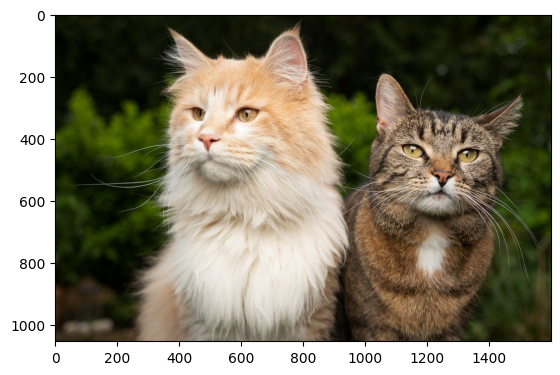

In [17]:
prediction_sample = "https://cdn.britannica.com/34/235834-050-C5843610/two-different-breeds-of-cats-side-by-side-outdoors-in-the-garden.jpg"

response = requests.get(prediction_sample)

with open("./prediction.jpg", 'wb') as f:
    f.write(response.content)

prediction = plt.imread("./prediction.jpg")

plt.imshow(prediction)
plt.show()

In [18]:
# Crops boxes and writes images to files
def images_to_file_prediction(image, predicted_rectangles, path="."):

    if not os.path.exists(f"{path}/"):
        os.makedirs(f"{path}/")

    i_id = 0

    for predicted_rectangle in predicted_rectangles:
        file_name = f"{path}/{i_id}.jpg"
        cropped_image = image[predicted_rectangle[2]:predicted_rectangle[3], predicted_rectangle[0]:predicted_rectangle[1]]
        img = Image.fromarray(cropped_image, 'RGB')
        img2 = img.resize((227,227), Image.ANTIALIAS)
        img2.save(file_name)
        i_id +=1

In [20]:
predicton_rectangles = region_proposals(prediction)
images_to_file_prediction(prediction, predicton_rectangles, path="./prediction/region")

<ipython-input-18-9ac30c962537>:13: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img2 = img.resize((227,227), Image.ANTIALIAS)


In [21]:
# When doing prediction ALWAYS set the shuffle parameter to False. Otherwise you can't trace the order of files correctly.
prediction_data = keras.utils.image_dataset_from_directory("./prediction", image_size=(227,227), shuffle=False)

# Model prediction
prediction_output = model.predict(prediction_data, batch_size=1)

Found 6226 files belonging to 1 classes.
195/195 [==============================] - 11s 52ms/step


In [22]:
# Converts rectangles from (x, y, w, h) to (x1, y1, x2, y2)
def _restructure_rectangles_xy(old_rects):

    x1 = old_rects[:,0]
    x2 = old_rects[:,1]
    y1 = old_rects[:,2]
    y2 = old_rects[:,3]

    rects_new = old_rects.copy()
    rects_new[:,1] = x1
    rects_new[:,0] = y1
    rects_new[:,3] = x2
    rects_new[:,2] = y2
    return rects_new

new_pred_rects = _restructure_rectangles_xy(predicton_rectangles)

In [23]:
# Method that "prunes away boxes that have high intersection-over-union (IOU) overlap with previously selected boxes" (Tensorflow Docs)
predictions = tf.image.non_max_suppression(new_pred_rects, prediction_output[:,0], max_output_size=3, iou_threshold=0.5)

# Take the selected predictions
selected_predictions = prediction_output[predictions.numpy()]

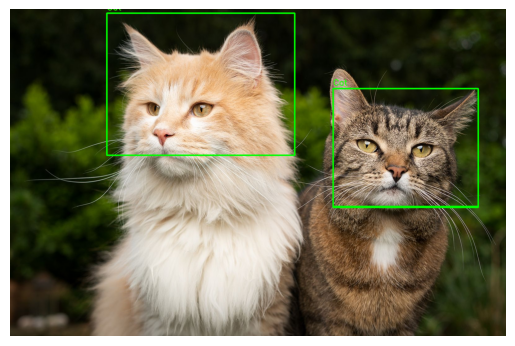

In [24]:
image = plt.imread("./prediction.jpg")

# Draw the bounding box and add label text
for ind, ind_rect in enumerate(predictions.numpy()):
    img_index = int(prediction_data.file_paths[ind_rect].split("/")[-1].split(".")[0])
    rectangle_coordinates = predicton_rectangles[img_index].astype(int)
    label = 'Cat'
    score = selected_predictions[ind, 0]

    # Draw the bounding box
    cv2.rectangle(image, (rectangle_coordinates[0], rectangle_coordinates[2]),
                  (rectangle_coordinates[1], rectangle_coordinates[3]), (0, 255, 0), 3)

    # Add label text
    text = f'{label}'
    cv2.putText(image, text, (rectangle_coordinates[0], rectangle_coordinates[2] - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36, 255, 12), 2)

plt.imshow(image)
plt.axis('off')
plt.show()